In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from joblib import load
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

2022-05-05 12:35:08.248656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-05 12:35:08.248713: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load Data and Models

In [2]:
# For the rare mode version=9.0.4.
version = '9.0.4'

test = pd.read_csv(f'../data_files/{version}/test.csv', index_col=[0])
X_test = test.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_test = test.category

In [3]:
nn = tf.keras.models.load_model(f'../neural_network/models/v9.0.5')
knn = load(f'../classification_methods/models/KNN_9.0.5.joblib')
rfc = load(f'../classification_methods/models/RFC_9.0.5.joblib')
dtc = load(f'../classification_methods/models/DTC_9.0.5.joblib')
xgb = load(f'../classification_methods/models/XGB_9.0.5.joblib')

models = {'NN': nn, 'KNN': knn, 'RFC': rfc, 'DTC': dtc, 'XGB': xgb}

2022-05-05 12:35:46.204932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-05 12:35:46.205018: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-05 12:35:46.205064: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eprexb.ph.bham.ac.uk): /proc/driver/nvidia/version does not exist
2022-05-05 12:35:46.205872: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/user211/envs/scientific/lib64/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying t

## Evaluate Efficiency

In [4]:
predictions = {
    'NN': np.squeeze(nn.predict(X_test)),
    'RFC': np.squeeze(rfc.predict_proba(X_test.to_numpy())[:,1]),
    'DTC': np.squeeze(dtc.predict_proba(X_test.to_numpy())[:,1]),
    'KNN': np.squeeze(knn.predict_proba(X_test.to_numpy())[:,1]),
    'XGB': np.squeeze(xgb.predict_proba(X_test)[:,1])
}

2022-05-05 12:36:15.049313: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/home/user211/envs/scientific/lib64/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [5]:
predicted_classes = {
    k: v for (k, v) in zip(list(predictions.keys()), [np.where(i > 0.7, 1, 0) for i in predictions.values()])
}

In [6]:
for key, value in predicted_classes.items():
    test[f'Pred{key}'] = value

In [24]:
total_signal = test['category'].value_counts()[1]
total_bg = test['category'].value_counts()[0]

N = 7396

print('Predicted Efficiencies (Rare Mode)')
for model_name in predicted_classes.keys():
    correct_signal = np.count_nonzero(np.logical_and(test[f'Pred{model_name}']==1,test['category']==1))
    correct_bkg = np.count_nonzero(np.logical_and(test[f'Pred{model_name}']==0,test['category']==0))
    
    es = correct_signal/total_signal
    eb = correct_bkg/total_bg
    
    errs = (np.sqrt(es * (1-es)/N), np.sqrt(es * (1-es)/N))
    errb = (np.sqrt(eb * (1-eb)/N), np.sqrt(eb * (1-eb)/N))
    
    print(f'{model_name}\tSignal Eff = {es:.3f}(+{errs[0]:.4f}-{errs[1]:.4f})%\n\tBkg. Eff = {eb:.3f}(+{errb[0]:.4f}-{errb[1]:.4f})%')

Predicted Efficiencies (Rare Mode)
NN	Signal Eff = 0.906(+0.0034-0.0034)%
	Bkg. Eff = 0.97(+0.0018-0.0018)%
RFC	Signal Eff = 0.927(+0.0030-0.0030)%
	Bkg. Eff = 0.96(+0.0024-0.0024)%
DTC	Signal Eff = 0.955(+0.0024-0.0024)%
	Bkg. Eff = 0.83(+0.0044-0.0044)%
KNN	Signal Eff = 0.913(+0.0033-0.0033)%
	Bkg. Eff = 0.96(+0.0022-0.0022)%
XGB	Signal Eff = 0.959(+0.0023-0.0023)%
	Bkg. Eff = 0.95(+0.0026-0.0026)%


# Same for Normalisation Mode

In [25]:
norm = pd.read_csv(f'../data_files/8.0.4/test.csv', index_col=[0])
X_test = norm.drop(['category', 'Lb_M', 'IsSimulated', 'QSQR'], axis=1)
y_test = norm.category

In [26]:
nn = tf.keras.models.load_model('models/NN_8.0.5')
knn = load(f'models/KNN_8.0.5.joblib')
rfc = load(f'models/RFC_8.0.5.joblib')
dtc = load(f'models/DTC_8.0.5.joblib')
xgb = load(f'models/XGB_8.0.5.joblib')

In [27]:
predictions = {
    'NN': np.squeeze(nn.predict(X_test)),
    'RFC': np.squeeze(rfc.predict_proba(X_test.to_numpy())[:,1]),
    'DTC': np.squeeze(dtc.predict_proba(X_test.to_numpy())[:,1]),
    'KNN': np.squeeze(knn.predict_proba(X_test.to_numpy())[:,1]),
    'XGB': np.squeeze(xgb.predict_proba(X_test)[:,1])
}

predicted_classes = {
    k: v for (k, v) in zip(list(predictions.keys()), [np.where(i > 0.7, 1, 0) for i in predictions.values()])
}

for key, value in predicted_classes.items():
    norm[f'Pred{key}'] = value

/home/user211/envs/scientific/lib64/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/user211/envs/scientific/lib64/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/user211/envs/scientific/lib64/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/user211/envs/scientific/lib64/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [28]:
predictions['NN'].shape

(12806,)

In [29]:
total_signal = norm['category'].value_counts()[1]
total_bg = norm['category'].value_counts()[0]

N = 12086

print('Predicted Efficiencies (Rare Mode)')
for model_name in predicted_classes.keys():
    correct_signal = np.count_nonzero(np.logical_and(norm[f'Pred{model_name}']==1,norm['category']==1))
    correct_bkg = np.count_nonzero(np.logical_and(norm[f'Pred{model_name}']==0,norm['category']==0))
    
    es = correct_signal/total_signal
    eb = correct_bkg/total_bg
    
    errs = (np.sqrt(es * (1-es)/N), np.sqrt(es * (1-es)/N))
    errb = (np.sqrt(eb * (1-eb)/N), np.sqrt(eb * (1-eb)/N))
    
    print(f'{model_name}\tSignal Eff = {es:.3f}(+{errs[0]:.4f}-{errs[1]:.4f})%\n\tBkg. Eff = {eb:.2f}(+{errb[0]:.4f}-{errb[1]:.4f})%')

Predicted Efficiencies (Rare Mode)
NN	Signal Eff = 0.882(+0.0029-0.0029)%
	Bkg. Eff = 0.98(+0.0013-0.0013)%
RFC	Signal Eff = 0.762(+0.0039-0.0039)%
	Bkg. Eff = 0.98(+0.0013-0.0013)%
DTC	Signal Eff = 0.724(+0.0041-0.0041)%
	Bkg. Eff = 0.95(+0.0019-0.0019)%
KNN	Signal Eff = 0.829(+0.0034-0.0034)%
	Bkg. Eff = 0.97(+0.0015-0.0015)%
XGB	Signal Eff = 0.716(+0.0041-0.0041)%
	Bkg. Eff = 0.95(+0.0019-0.0019)%


In [7]:
# Make the plots
bar_data = np.array([cs_blind, cs_bands]).T
bar_data = np.round(bar_data, 2)
bar_data

array([[88.23, 33.33],
       [76.27,  0.  ],
       [72.43,  0.  ],
       [82.9 , 33.33],
       [71.65, 33.33]])

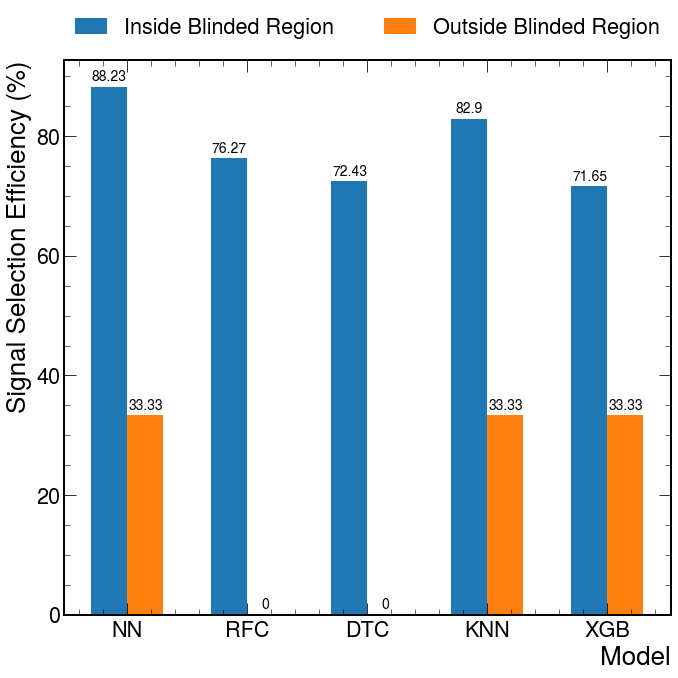

In [8]:
fig, ax = plt.subplots(1, 1)
width = 0.3
rects1 = ax.bar(np.arange(5)-width/2, bar_data[:,0], width=width, label='Inside Blinded Region')
rects2 = ax.bar(np.arange(5)+width/2, bar_data[:,1], width=width, label='Outside Blinded Region')
ax.set_xticks(np.arange(5), ["NN", "RFC", "DTC", "KNN", "XGB"])
plt.xlabel('Model')
plt.ylabel('Signal Selection Efficiency (%)')
ax.bar_label(rects1, padding=3, fontsize=14)
ax.bar_label(rects2, padding=3, fontsize=14)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)
plt.tight_layout()
plt.savefig('../images/ModelEval/Predicted_Sig_Norm_Efficiency_ByRegion.png')
plt.show()